In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
#import mpl_scatter_density
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import skimage
import plotly.graph_objects as go

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from statistics import mode
from matplotlib import transforms
import netCDF4

import os
import moviepy.video.io.ImageSequenceClip
from IPython.display import Video

In [2]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

In [3]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [4]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [5]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [6]:
Test_Images = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Unscaled_Big_Alt_Multi_Sim_Randomized_Space_Time_W_Test.npy')
Test_Images_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_W_Test.npy')

In [7]:
lat_test = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Big_Alt_Multi_Sim_Randomized_Space_Time_Lat_Test.npy', mmap_mode="r")
lon_test = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Big_Alt_Multi_Sim_Randomized_Space_Time_Lon_Test.npy', mmap_mode="r")

lat_test_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_Lat_Test.npy', mmap_mode="r")
lon_test_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_Lon_Test.npy', mmap_mode="r")

In [8]:
zero_k_RECON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/Anomalies/Randomized_0K_RECON_Data__3100.npy")
four_k_RECON = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/SPCAM/0K_BIG_SPCAM_RECON_3312.npy")

zero_k_RECON_4K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/model_graphs/Anomalies/Randomized_4K_RECON_Data__3100.npy")
four_k_RECON_4K = np.load("/fast/gmooers/gmooers_git/CBRAIN-CAM/MAPS/DYAMOND_VAEs/model_graphs/Anomalies/Matrix/SPCAM/4K_BIG_SPCAM_RECON_3312.npy")

# Look at the Data

In [9]:
zero_k_RECON[zero_k_RECON > 14953181] = 14953181
zero_k_RECON_4K[zero_k_RECON_4K > 14953181] = 14953181

In [10]:
Recon_Error = np.abs(four_k_RECON - zero_k_RECON)
Recon_Error_4K = np.abs(four_k_RECON_4K - zero_k_RECON_4K)

# Extract 95th Percentile

In [11]:
Test_Images_95 = Test_Images[Recon_Error <= np.percentile(Recon_Error, 1)]
Test_Images_95_4K = Test_Images_4K[Recon_Error_4K <= np.percentile(Recon_Error_4K, 1)]

# Make the W'W' Profiles

In [12]:
ww_test_0K = np.empty(Test_Images_95.shape)
ww_test_4K = np.empty(Test_Images_95_4K.shape)
for i in range(len(Test_Images_95)):
    ww_test_0K[i,:,:] = ((Test_Images_95[i,:,:] - np.nanmean(np.squeeze(Test_Images_95[i,:,:]),axis=1)[:,None])**2)**0.5
    ww_test_4K[i,:,:] = ((Test_Images_95_4K[i,:,:] - np.nanmean(np.squeeze(Test_Images_95_4K[i,:,:]),axis=1)[:,None])**2)**0.5

In [13]:
ww_profiles_0K = np.empty(shape=(len(ww_test_0K)*len(ww_test_0K[0][0]), len(ww_test_0K[0])))
ww_profiles_4K = np.empty(shape=(len(ww_test_4K)*len(ww_test_4K[0][0]), len(ww_test_4K[0])))

for i in range(len(ww_profiles_0K[0])):
    ww_profiles_0K[:,i] = ww_test_0K[:,i,:].flatten()
    ww_profiles_4K[:,i] = ww_test_4K[:,i,:].flatten()

In [14]:
ww_mean_profile_0K = np.mean(ww_profiles_0K, axis = 0)
ww_25_profile_0K = np.percentile(ww_profiles_0K, 25, axis = 0)
ww_75_profile_0K = np.percentile(ww_profiles_0K, 75, axis = 0)

ww_mean_profile_4K = np.mean(ww_profiles_4K, axis = 0)
ww_25_profile_4K = np.percentile(ww_profiles_4K, 25, axis = 0)
ww_75_profile_4K = np.percentile(ww_profiles_4K, 75, axis = 0)

# Make the plot

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found.

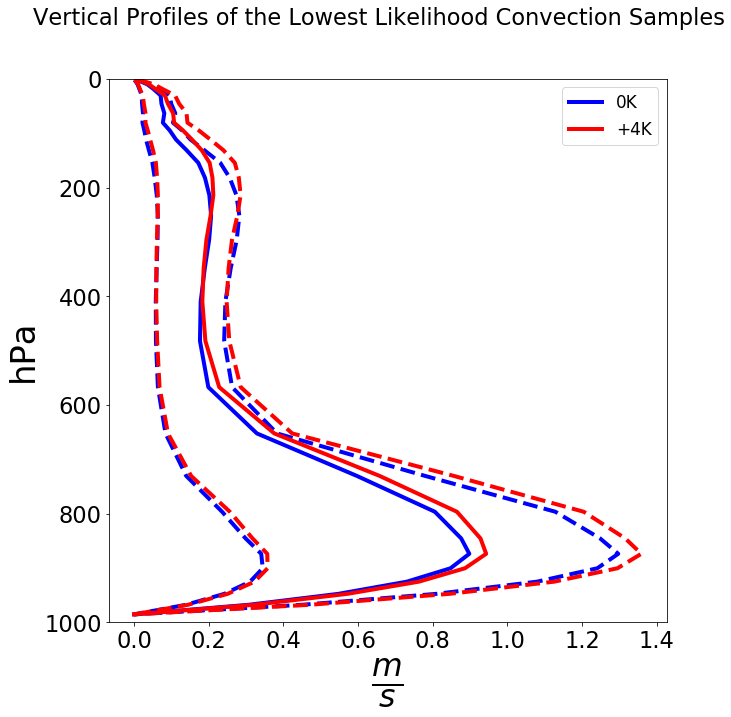

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(np.flipud(ww_mean_profile_0K), Pressures_real[:-1]/100.0, color="blue", label="0K")
ax.plot(np.flipud(ww_25_profile_0K), Pressures_real[:-1]/100.0, color="blue", linestyle="dashed")
ax.plot(np.flipud(ww_75_profile_0K), Pressures_real[:-1]/100.0, color="blue", linestyle="dashed")

ax.plot(np.flipud(ww_mean_profile_4K), Pressures_real[:-1]/100.0, color="red", label="+4K")
ax.plot(np.flipud(ww_25_profile_4K), Pressures_real[:-1]/100.0, color="red", linestyle="dashed")
ax.plot(np.flipud(ww_75_profile_4K), Pressures_real[:-1]/100.0, color="red", linestyle="dashed")

ax.legend(fontsize=fz*0.75)
ax.set_ylim(0,1000)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel(r"$\frac{m}{s}$", fontsize=fz*2.0)
ax.set_ylabel("hPa", fontsize=fz*1.5)
plt.suptitle("Vertical Profiles of the Lowest Likelihood Convection Samples", fontsize = fz)
plt.savefig("../Figures/Figure_S10.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("../Figures/Figure_S10.pdf", bbox_inches='tight',pad_inches = 0)